In [1]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from utils import export, show_side_by_side, show_features
from statistics import Statistics
from prob_opt import PredictStructs

In [2]:
data_dir = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp2'
mcss_dir = 'mcss/mcss7'

chembl_file = 'best_affinity.txt'

stats_prots = ['SIGMA1','5HT2B','AR','B1AR']#,'B1AR']
pred_prots = ['TRPV1']

features = {
    'mcss':[],
    'hbond':[2,3]#,
    #'sb2':[1],
    #'sb':[4],
    #'pipi':[6]
    #'picat':[7,8],
    #'contact':[11]
}

In [3]:
all_prots = stats_prots + pred_prots
all_data = Dataset(all_prots, data_dir, glide_dir, ifp_dir, mcss_dir)

# load in statistics ligands
ligands = {p: prot.lm.pdb for p,prot in all_data.proteins.items()}# if p in stats_prots}

all_data.load(ligands, load_fp=True, load_mcss=True)

In [4]:
num_stats_ligs = 50
num_stats_poses = 100
smooth = 0.02
normalize = True
stats = Statistics(all_data, stats_prots, num_stats_ligs, num_stats_poses, features, smooth, normalize)

#for f_name in features.keys():
#    print f_name#, stats.evidence.std[f_name]
#    stats.show_stats(f_name, raw=False, smoothed=True)
    #try:
    #    stats.show_stats_by_pair(f_name, raw=False, smoothed=True)
    #except:
    #    print 'ugh'
    #    continue

warning, only 2 ligands found for 5HT2B


In [ ]:
for f_name in features.keys():
    print f_name#, stats.evidence.std[f_name]
    stats.show_stats(f_name, raw=True, smoothed=False)

In [5]:
num_chembl = 9
num_poses = 100
t = 10

mcss_sort = 'mcss' in chembl_file

error = {}
chembl_ligs = {}

for p in pred_prots:
    prot = all_data.proteins[p]
    ps = PredictStructs(prot.docking[prot.lm.default_st], stats.evidence, features, num_poses, t)
    
    us_rmsds = []
    glide_rmsds = []
    
    for q in prot.lm.pdb:
        if q in ['droperidol_lig','pimozide_lig','6CM4_lig']: continue
        print q
        
        chembl_ligs[q] = prot.lm.get_similar(q, chembl_file, num=num_chembl, mcss_sort=mcss_sort)
        all_data.load({p:[q]+chembl_ligs[q]})
        
        best_cluster, all_scores, all_rmsds = ps.max_posterior([q]+chembl_ligs[q], verbose=True, restart=15,
                                                               sampling=3, en_landscape=False)
        
        #our_scores = ps.score_query(q, best_cluster)
        us_top = best_cluster[q]
        rmsds = [po.rmsd for po in prot.docking[prot.lm.default_st].ligands[q].poses[:num_poses]]
        print q, us_top, rmsds[us_top], 0, rmsds[0]
        us_rmsds.append(rmsds[us_top])
        glide_rmsds.append(rmsds[0])
              
        if True:#rmsds[us_top] > 2:
            best_cluster[q] = us_top
            error[q] = best_cluster
            
        #break
        
    print 'our ave rmsd:',np.mean(us_rmsds)
    print 'glide ave rmsd:',np.mean(glide_rmsds)

5IRX_lig
cluster -1, score 10.8869097644
cluster 0, score 72.7240309868
cluster 1, score 72.7240309868
cluster 2, score 75.5018954301
cluster 3, score 75.5018954301
cluster 4, score 75.5018954301
cluster 5, score 72.7240309868
cluster 6, score 75.5018954301
cluster 7, score 73.3505598236
cluster 8, score 75.5018954301
cluster 9, score 74.1492907914
cluster 10, score 75.5018954301
cluster 11, score 73.3505598236
cluster 12, score 72.7240309868
cluster 13, score 75.5018954301
cluster 14, score 75.5018954301
5IRX_lig 20 1.09531344491 0 5.14408433653
5IS0_lig
cluster -1, score 71.9078886539
cluster 0, score 66.110353634
cluster 1, score 71.9078886539
cluster 2, score 71.9078886539
cluster 3, score 66.110353634
cluster 4, score 69.1410321853
cluster 5, score 70.7347084709
cluster 6, score 71.9078886539
cluster 7, score 71.9078886539
cluster 8, score 20.4554683822
cluster 9, score 71.9078886539
cluster 10, score 71.9078886539
cluster 11, score 66.110353634
cluster 12, score 65.0395300384
clu

In [ ]:
print all_scores[0], all_rmsds[0]
plt.plot(all_rmsds,all_scores,'.')
plt.ylim(50,80)

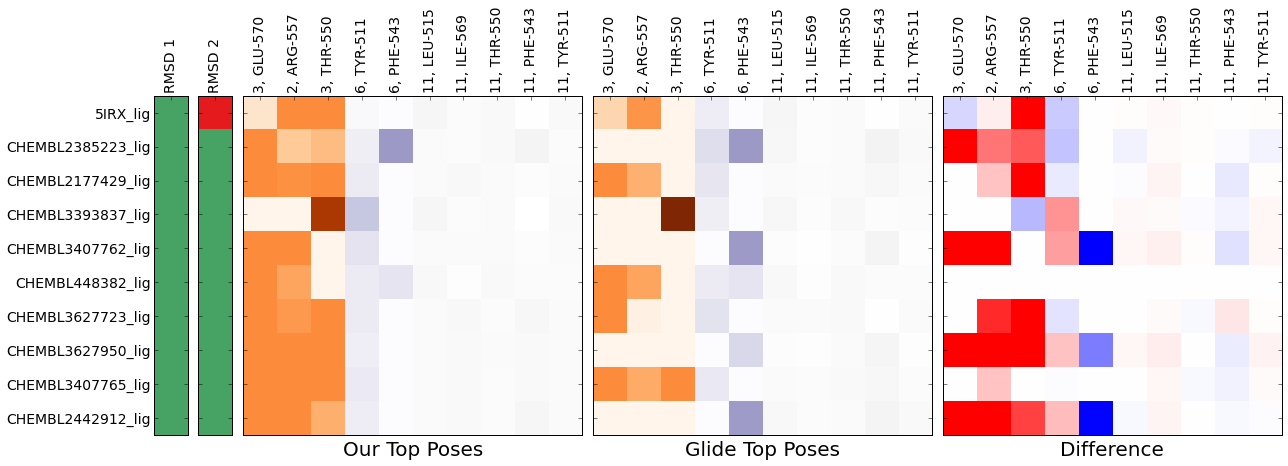

mcss probability matrix


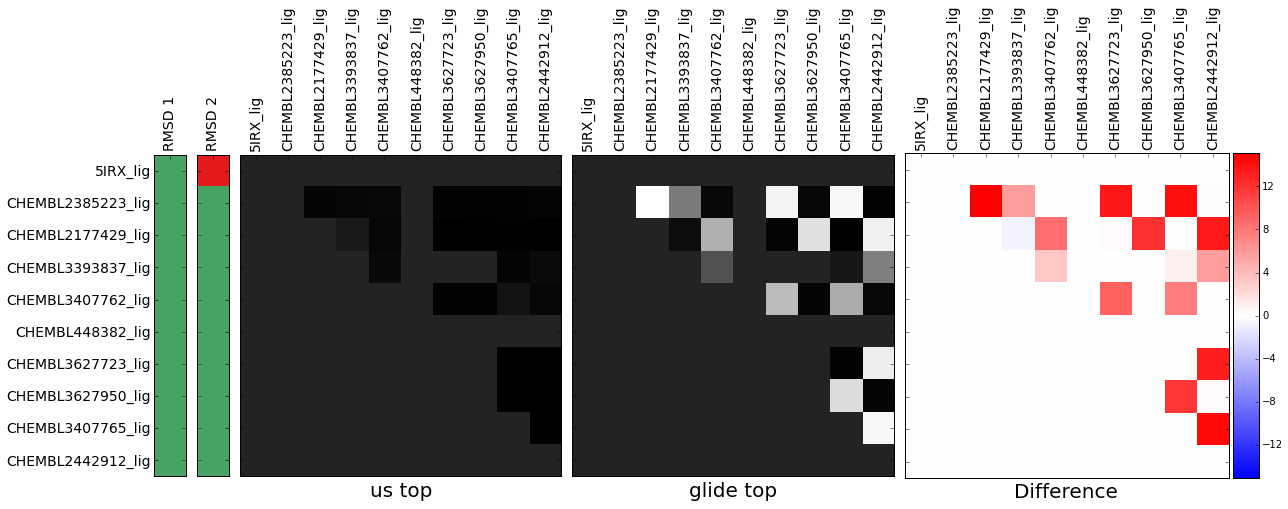

mcss x_k matrix


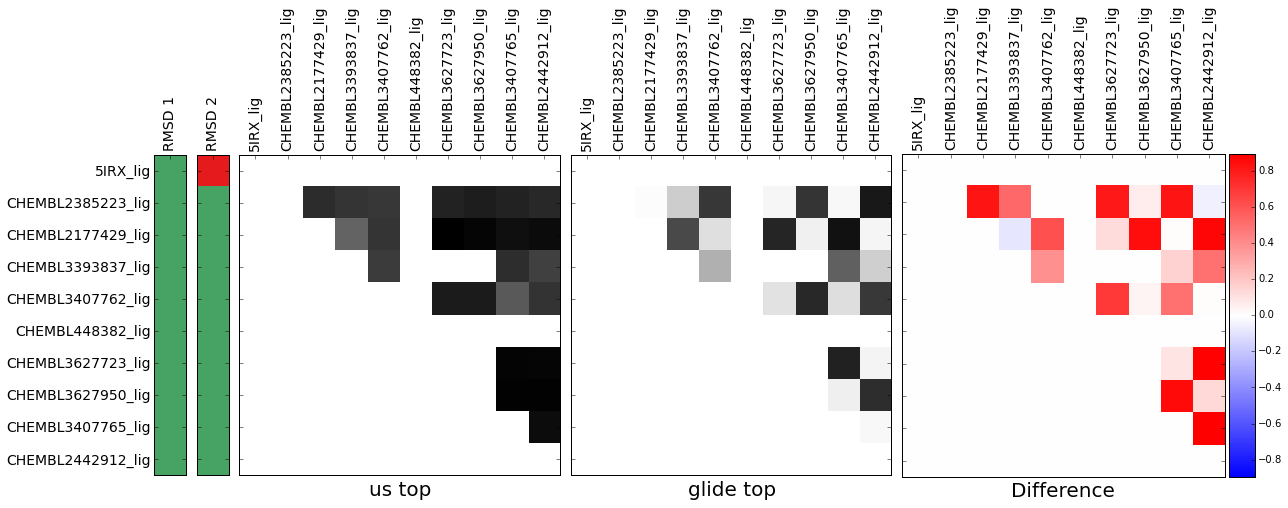

hbond probability matrix


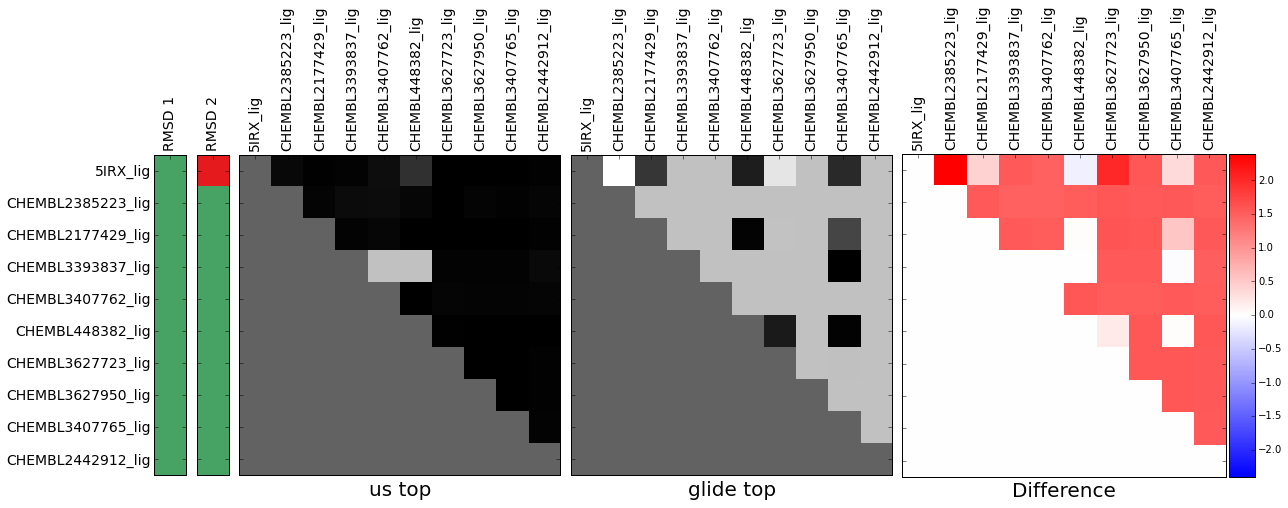

hbond x_k matrix


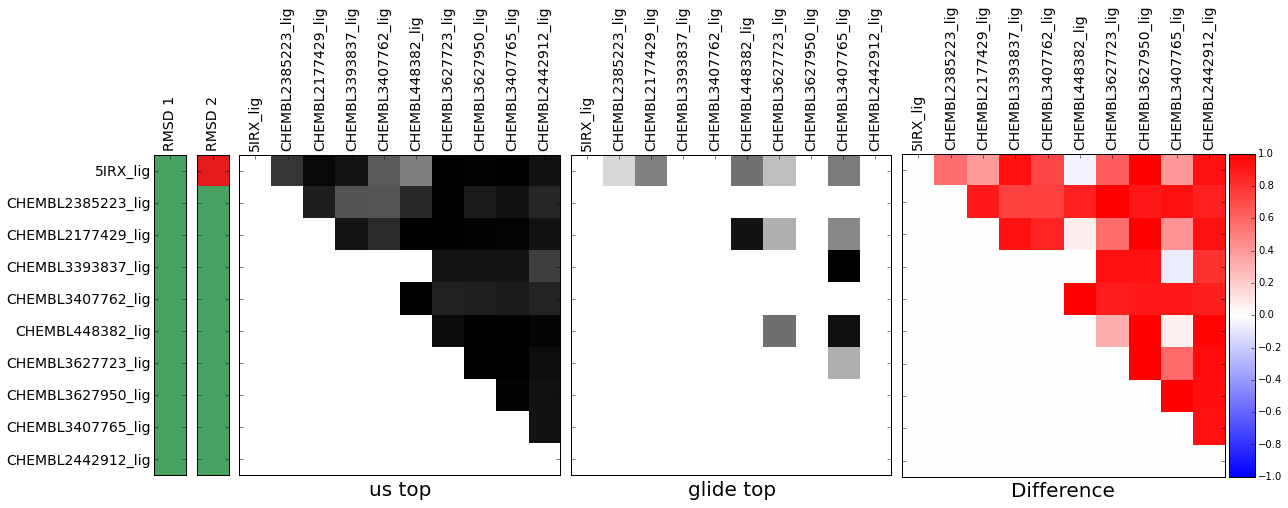

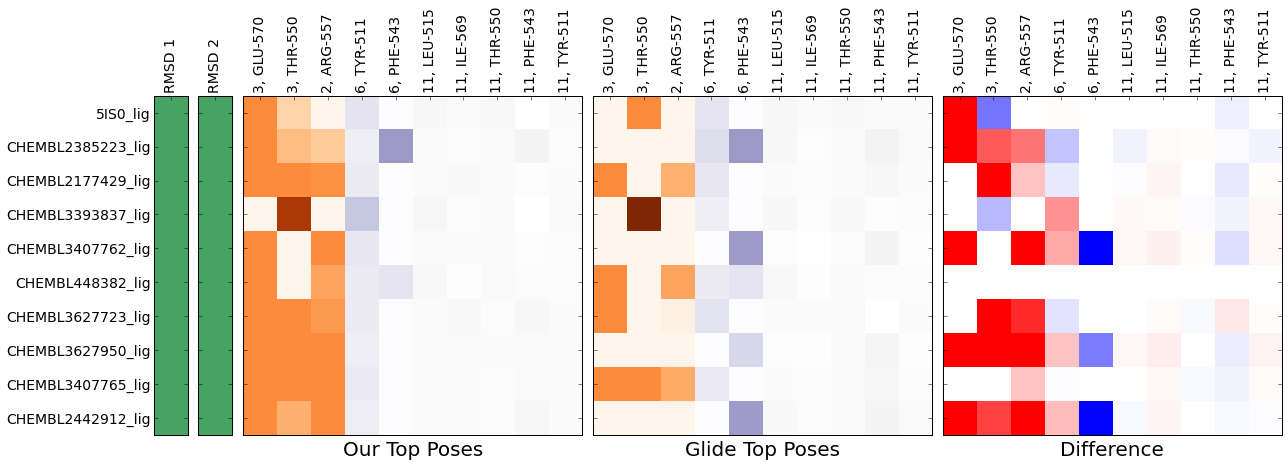

mcss probability matrix


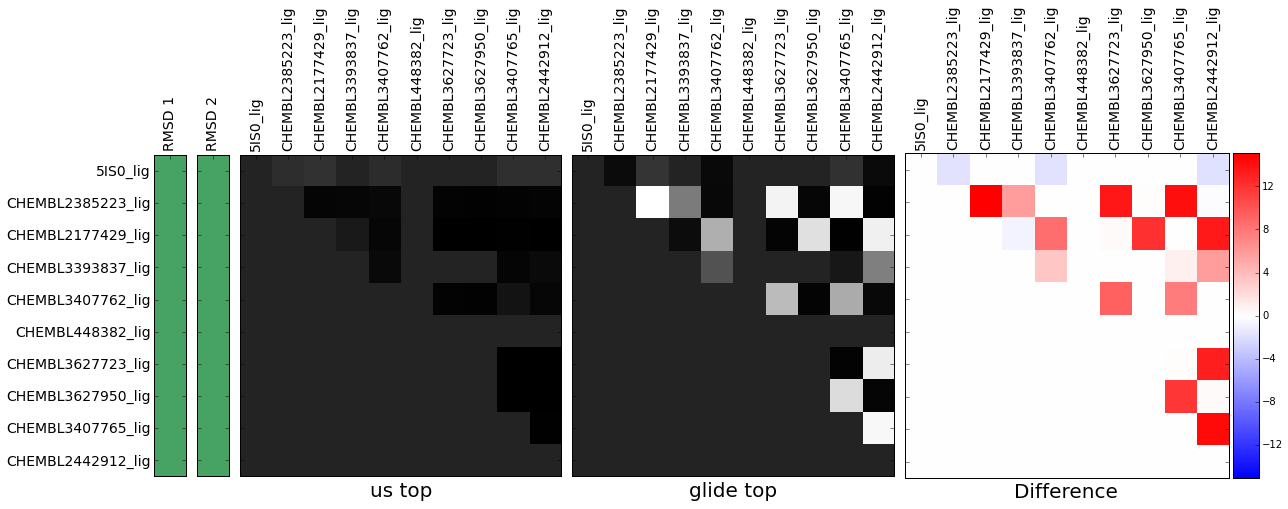

mcss x_k matrix


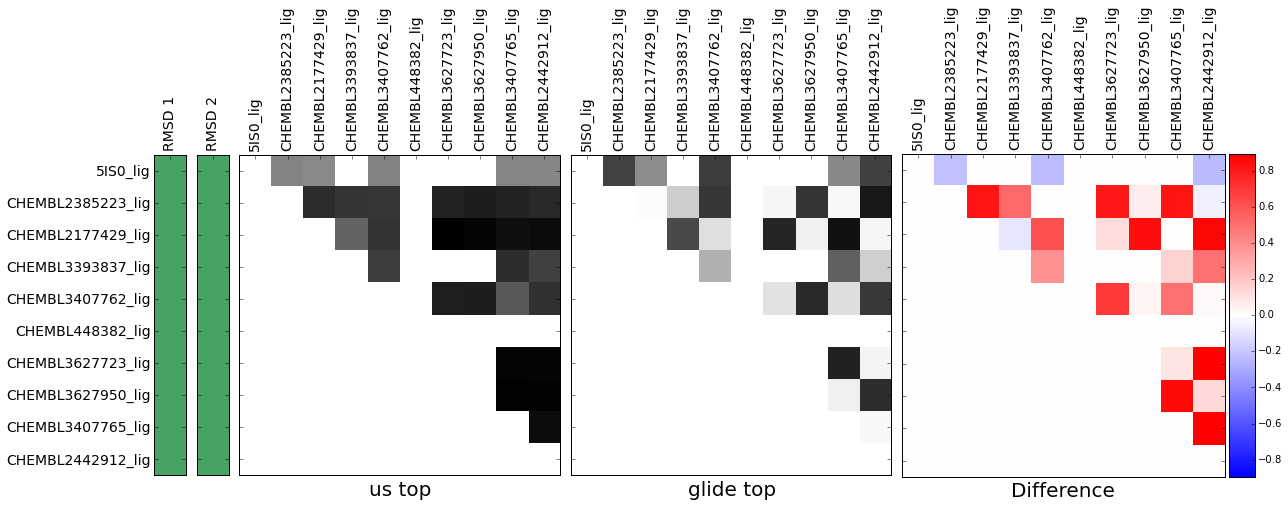

hbond probability matrix


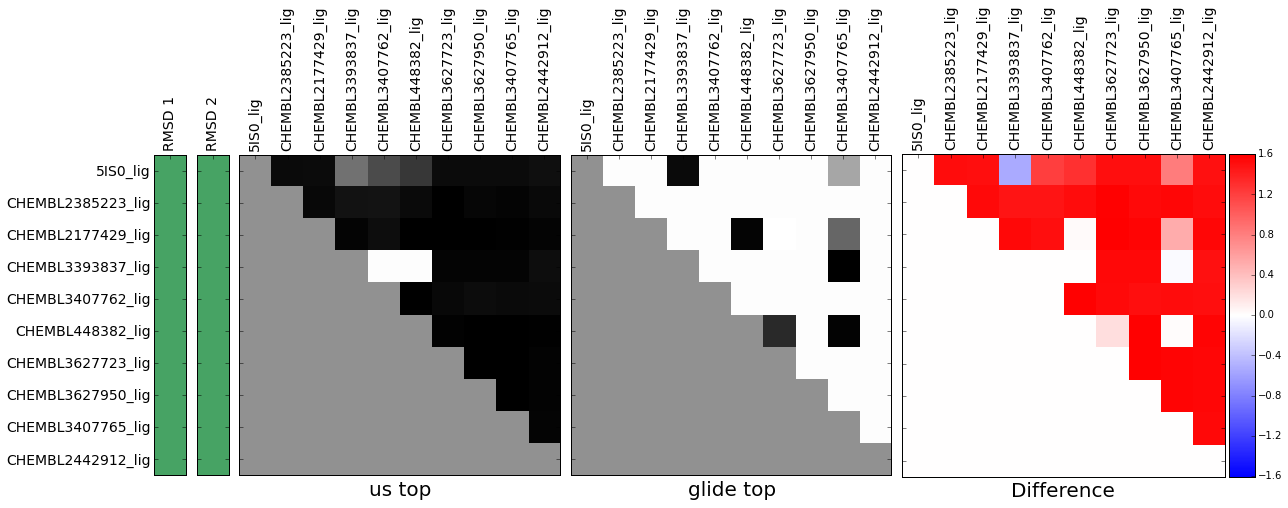

hbond x_k matrix


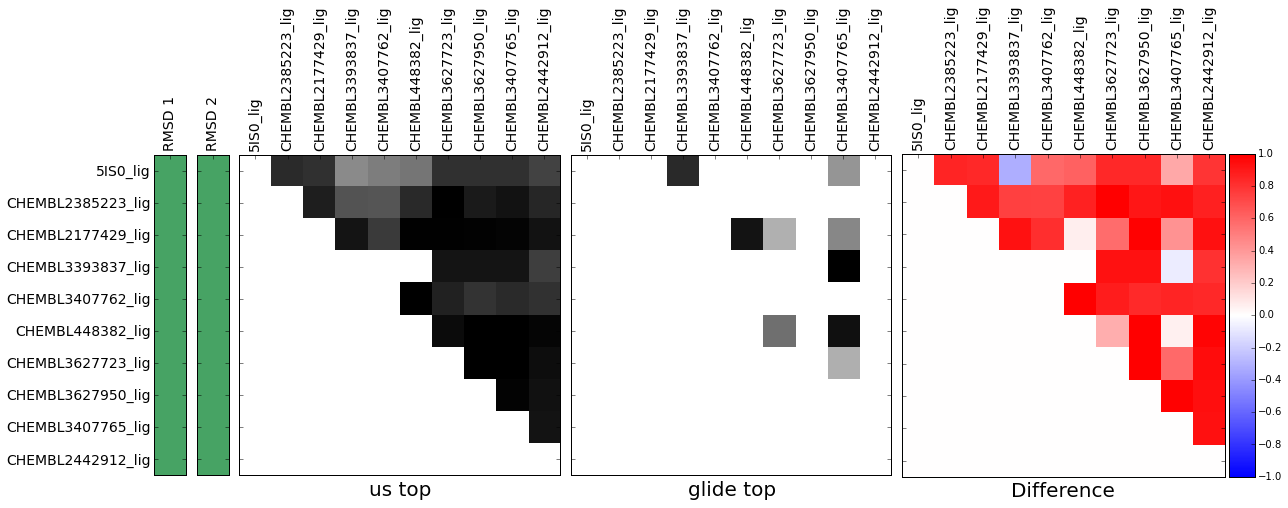

In [7]:
all_data.assign_weights({2:1,3:1,4:1,6:1,11:0.005})

size = 2
show_fp = True
show_prob = True
show_x = True
export_poses = True

for q, our_poses in error.items():
    glide_poses = {l:0 for l in our_poses}
    
    us_top = ps.get_poses(our_poses)
    glide_top = ps.get_poses(glide_poses)
    
    l_list = [q] + chembl_ligs[q]
    
    if show_fp:
        show_side_by_side(us_top, glide_top, l_list, 
                          t1='Our Top Poses', t2='Glide Top Poses', num_i=10, size=size)
    #continue
    for k,kdef in features.items():
        x1, log_p1 = ps.likelihood_and_feature_matrix(our_poses,k,lig_order=l_list)
        x2, log_p2 = ps.likelihood_and_feature_matrix({l:0 for l in l_list},k,lig_order=l_list)

        if show_prob and np.sum(log_p1) != 0:
            print k, 'probability matrix'
            minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
            maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))

            show_features(us_top, log_p1, glide_top, log_p2, l_list, 
                          'us top','glide top',size=size, mi=minval,ma=maxval)

        if show_x:
            print k, 'x_k matrix'
            minval = min(np.min(x1),np.min(x2))
            maxval = max(np.max(x1),np.max(x2))

            show_features(us_top, x1, glide_top, x2, l_list, 
                          'us top','glide top',size=size,mi=minval,ma=maxval)
            
    # this will show up in /scratch/PI/rondror/jbelk/method/outputs
    if export_poses: 
        export(data_dir, us_top, '{}_us_may'.format(q), p, 
               struct=prot.lm.default_st, verbose=False, glide_dir=glide_dir)
        #export(data_dir, glide_top, '{}_glide_'.format(q), p, 
        #       struct=prot.lm.default_st, verbose=False, glide_dir=glide_dir)